***
# Post-Block Assignment 1
***
Johan Hanekom <br>
20780893 <br>
16/11/2021
***
## Setup
Install the necessary updates and packages for the tutorial

In [1]:
# Run and print a shell command.
def run(cmd):
  print('>> {}'.format(cmd))
  !{cmd}
  print('')

run('pip install --upgrade pip')

# Install apache-beam.
run('pip install --quiet apache-beam')


>> pip install --upgrade pip

>> pip install --quiet apache-beam



# Get Data
Use the provided link to import the dataset

In [2]:
# Copy the input file into the local file system.
run('mkdir -p data')
run('wget https://storage.googleapis.com/bdt-beam/syn-internet-usage.csv -O data/usage.csv')

>> mkdir -p data

>> wget https://storage.googleapis.com/bdt-beam/syn-internet-usage.csv -O data/usage.csv
--2021-11-21 17:34:29--  https://storage.googleapis.com/bdt-beam/syn-internet-usage.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 74.125.143.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26903141 (26M) [text/csv]
Saving to: ‘data/usage.csv’

data/usage.csv      100%[===================>]  25.66M  --.-KB/s    in 0.1s    

2021-11-21 17:34:29 (178 MB/s) - ‘data/usage.csv’ saved [26903141/26903141]




# Import libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from matplotlib.dates import DateFormatter, DayLocator
import numpy as np
import apache_beam as beam
import re
from datetime import datetime
from apache_beam import window

# Question 1
**Perform initial exploratory data analysis to establish if outages have occurred in the provided data. Provide a working notebook to demonstrate your analyses and conclusion**

An exploratory analysis will provide insight into the dataset. A few questions will be considered:


1.   In what Zone did the outage occur?
2.   Wat what time did the outage occur?



In [4]:
# Create a smaller sample
! head -50000 data/usage.csv > data/small_usage.csv

In [5]:
# Read in the data
df = pd.read_csv("data/usage.csv", parse_dates=True)
df["Unnamed: 0"] = pd.to_datetime(df["Unnamed: 0"])
df.head()

,Unnamed: 0,bytes,user_id,zone
0,2021-09-27 00:00:00,0.0,c2b9546e,D
1,2021-09-27 00:01:00,0.0,c2b9546e,D
2,2021-09-27 00:02:00,0.0,c2b9546e,D
3,2021-09-27 00:03:00,0.0,c2b9546e,D
4,2021-09-27 00:04:00,0.0,c2b9546e,D


In [6]:
# Split per zone
df_A = df[df["zone"]=="A"]
df_B = df[df["zone"]=="B"]
df_C = df[df["zone"]=="C"]
df_D = df[df["zone"]=="D"]

In [7]:
# Get the users per zone
users_A = df_A["user_id"].unique()
users_B = df_B["user_id"].unique()
users_C = df_C["user_id"].unique()
users_D = df_D["user_id"].unique()

In [8]:
type(df["Unnamed: 0"][0])

pandas._libs.tslibs.timestamps.Timestamp

## Zone A

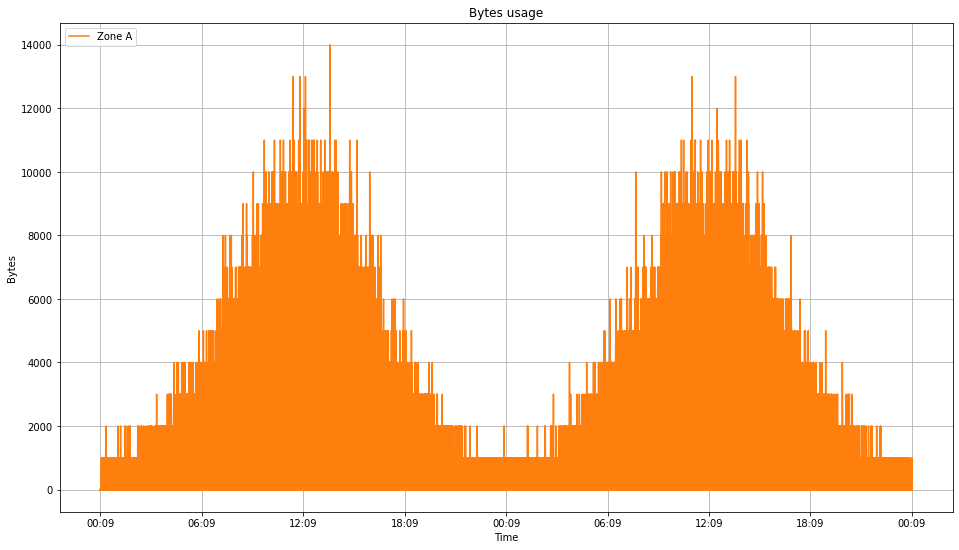

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))

# Specify how our lines should look
ax.plot(df_A["Unnamed: 0"], df_A["bytes"], color='tab:orange', label='Zone A')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Bytes')
ax.set_title('Bytes usage')
ax.grid(True)
ax.legend(loc='upper left')
ax.xaxis.set_major_formatter(DateFormatter('%H:%m'))

## Zone B

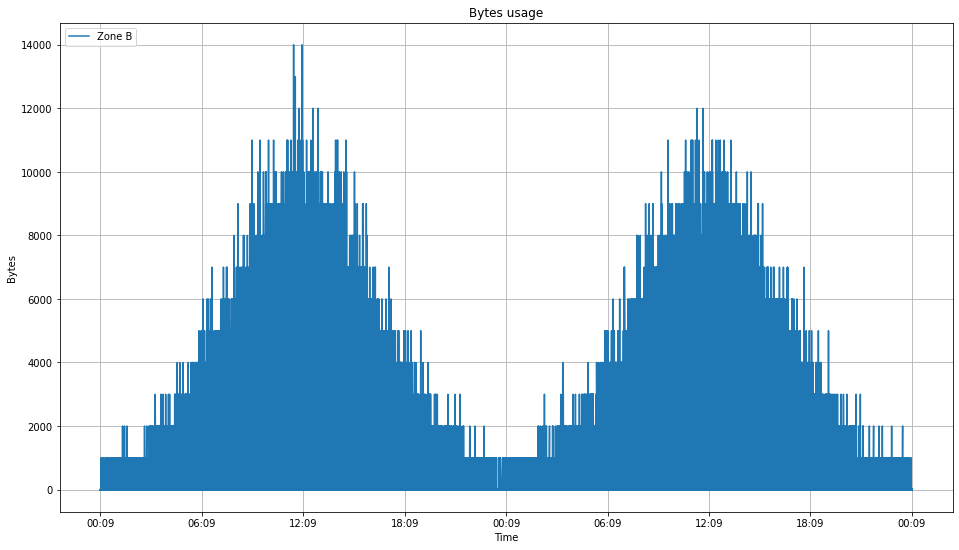

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))

# Specify how our lines should look
ax.plot(df_B["Unnamed: 0"], df_B["bytes"], color='tab:blue', label='Zone B')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Bytes')
ax.set_title('Bytes usage')
ax.grid(True)
ax.legend(loc='upper left')
ax.xaxis.set_major_formatter(DateFormatter('%H:%m'))

## zone C

It is clear from the figure below that an outage occured in Zone C at lunchtime on the second day.

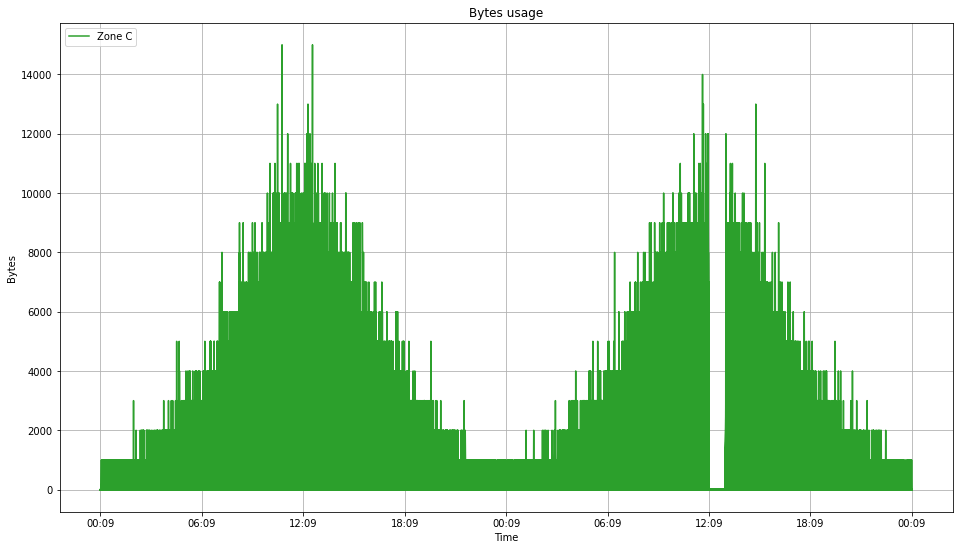

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))

# Specify how our lines should look
ax.plot(df_C["Unnamed: 0"], df_C["bytes"], color='tab:green', label='Zone C')


# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Bytes')
ax.set_title('Bytes usage')
ax.grid(True)
ax.legend(loc='upper left')
ax.xaxis.set_major_formatter(DateFormatter('%H:%m'))

## Zone D

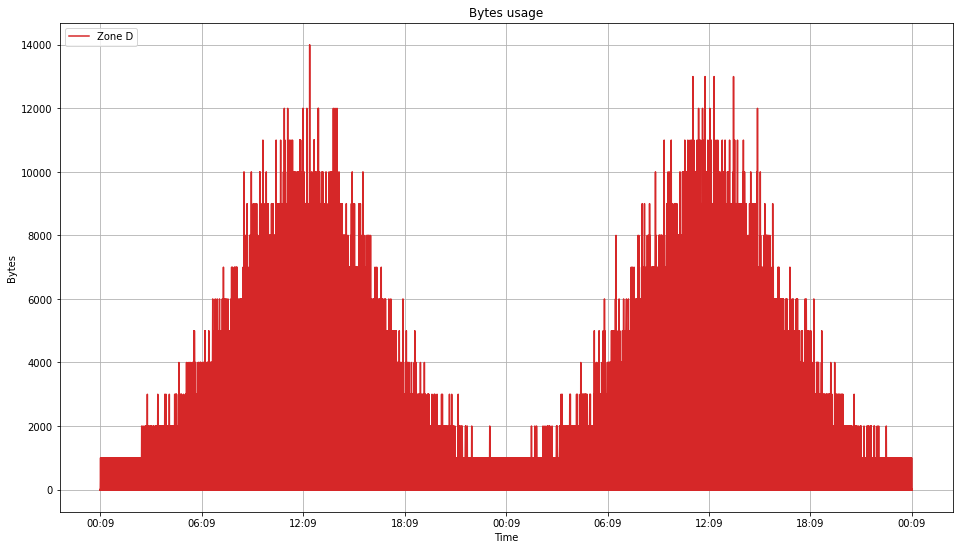

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(df_D["Unnamed: 0"], df_D["bytes"], color='tab:red', label='Zone D')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Bytes')
ax.set_title('Bytes usage')
ax.grid(True)
ax.legend(loc='upper left')
ax.xaxis.set_major_formatter(DateFormatter('%H:%m'))

# Question 2
## Implement a python version first

### Consider a moving average
Here a moving average will be used as an anomaly detection. The moving average provides a much smoother movement of demand than the raw data. 

A gradient will then be calculated as the data moves. Should the gradient be too high, it will flag be visable on the plots!

In [13]:
def get_gradient(lst, window=5):

  # Check that enough data was provided
  size = len(lst)
  if len(lst)<window:
    print("Error: Not enough data")
  
  # Provide a prefix. This will ensure that a list with the same length as the input is returned
  gradient_lst = [0]*(window-1)

  # Loop thorugh the list
  for i in range(window-1,size):

    # Extract two neighbouring elements, window=5 indeces apart
    last = i
    first = i-window+1

    # Make sure that the first element is not equal to zero. It it is, assign it
    # a value close to 0, for example x=1
    x = lst[first] 
    if lst[first] == 0:
      x = 1

    # Calculate the gradient change
    gradient_lst.append((abs(lst[last]-x)/x))

  return gradient_lst

# Test the function
l = [1,2,3,4,5,0,0,0,10]
get_gradient(l, window=4)

[0, 0, 0, 3.0, 1.5, 1.0, 1.0, 1.0, 9.0]

Now plot the moving average and anomaly detection for one of the users of zone C!

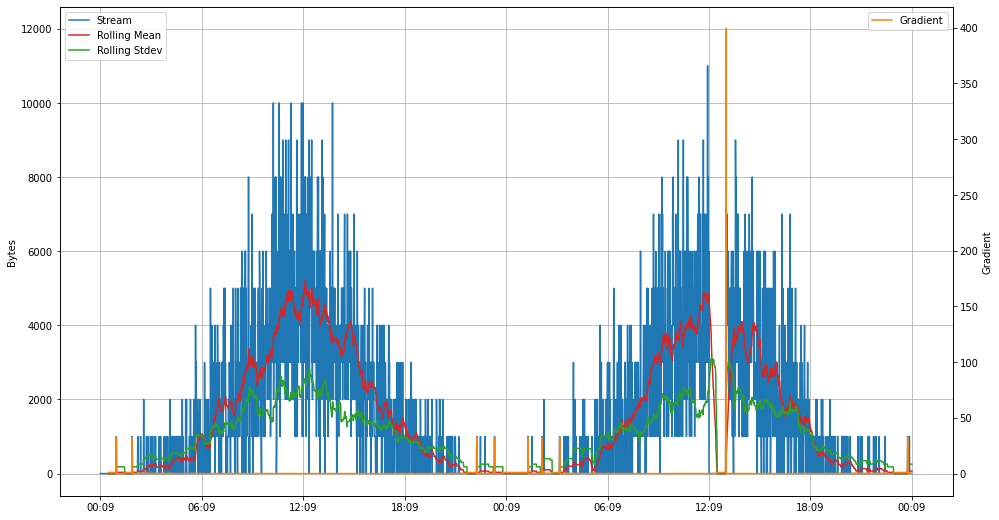

In [14]:
N = 30 # Window size (for the rolling average)
user = 8 # Which user to consider
W = 2 # window size for the gradient diffefrence

# Filter for the user
df_tail = df_C[df_C["user_id"] == users_C[user]]
# df_tail = df_C.groupby(by='Unnamed: 0', axis=0).mean()

# Calculate the rolling average
rolling_mean = df_tail['bytes'].rolling(window=N).mean()

# Calculate the rolling standard deviation
rolling_std = df_tail['bytes'].rolling(window=N).std()

# Calculate the gradient (anomaly detection)
gradient = get_gradient(list(rolling_mean), window = W)

# Plotting the data
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(df_tail["Unnamed: 0"],df_tail['bytes'], color = "tab:blue", label = "Stream")
ax.plot(df_tail["Unnamed: 0"],rolling_mean, color = "tab:red", label = "Rolling Mean")
ax.plot(df_tail["Unnamed: 0"],rolling_std, color = "tab:green", label = "Rolling Stdev")
ax.set_ylabel("Bytes")
ax.grid(True)
ax.legend(loc='upper left')

# Plot the anomaly detection
ax2 = ax.twinx()
ax2.plot(df_tail["Unnamed: 0"],gradient, color = "tab:orange", label = "Gradient")
ax2.set_ylabel("Gradient")
ax2.legend(loc='upper right')

ax.xaxis.set_major_formatter(DateFormatter('%H:%m'))

From here, it can be concluded that the anomaly detection algorithm succeeded in detecting the anomaly at noon on the second day.

# Implement Streaming Algorithm

The pipeline has the following steps..


1.   Read the data as a text
2.   Format the date as a timestamp
3.   Add timestamps to element's metadata
4.   Use a sliding window with a duration of 3 minutes, update every minute (determined this emperically
5.   Determine the rolling average
6.   Convert the window information to a readable format
7.   Buffer three items together. This is used to detect any drastic dips in the rolling average.

The anomaly detection stream was able to pick up the anomaly as shown in the screenshot below. Granted, the algorithm also flags a few false entries, but this can be investigated by an admin.



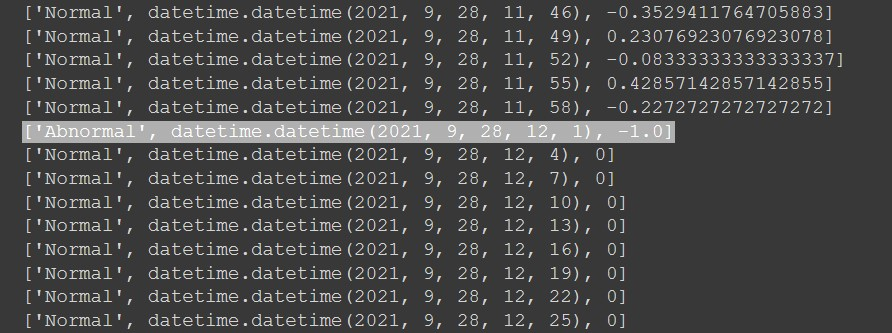

In [15]:
# View the header of the data
! head -3 data/usage.csv

,bytes,user_id,zone
2021-09-27 00:00:00,0.0,c2b9546e,D
2021-09-27 00:01:00,0.0,c2b9546e,D


In [16]:
user_header = ['date','bytes','user_id','zone']

# Transform the data and format the date to be a date-time timestamp format
class Transform(beam.DoFn):
  def process(self, element):
    row_list =  element.split(',')
    yield [datetime.strptime(row_list[0], '%Y-%m-%d %X').timestamp(),float(row_list[1]),row_list[2], row_list[3]]

In [17]:
# This function prints the window data as a readable format
def get_window(element,  timestamp=beam.DoFn.TimestampParam):
    return [ datetime.fromtimestamp(int(timestamp) + 1), element]

# The Group class is used to batch two (or more elements together)
# See https://stackoverflow.com/questions/49495336/how-to-create-groups-of-n-elements-from-a-pcollection-apache-beam-python
class Group(beam.DoFn):
  def __init__(self, n):
     self._n = n
     self._buffer = []

  def process(self, element):
     self._buffer.append(element)
     if len(self._buffer) == self._n:
        yield list(self._buffer)
        self._buffer = []

  def finish_bundle(self):
     if len(self._buffer) != 0:
        yield list(self._buffer)
        self._buffer = []

# The function to detect the anomaly. Similar to the one implemented in python
def anaomaly(batch):

  # Extract the bytes of the first value
  entry_1 = float(batch[0][1])

  # Extract the bytes of the second value
  entry_2 = float(batch[2][1])

  # Extract the timestamp of the first value
  time1 = batch[0][0]

  # Extract the timestamp of the second value
  time2 = batch[2][0]

  if entry_1>0:
    pct_change = (entry_2-entry_1)/entry_1
    if pct_change < -0.8:
      status="Abnormal"
    else: 
      status = "Normal"
  else:
    pct_change = 0
    status = "Normal"


  return [status,time1, pct_change]


with beam.Pipeline() as pipeline:
  (pipeline 
      | 'Read the data into the pipeline' >> beam.io.ReadFromText('data/usage.csv', skip_header_lines=1)
      | 'Fromat the date as timestamp' >> beam.ParDo(Transform())
      | 'Only consider zone C' >> beam.Filter(lambda x: x[3] == 'C')
      | 'Sonly consider this user' >> beam.Filter(lambda x: x[2] == 'eef622bc') # Unnecessary. Works withou this filter. It's just nice to work with less data
      | 'Add timestamp to elements metadata' >> beam.Map(lambda x: beam.window.TimestampedValue(x[1], x[0])) 
      | 'Construct a sliding window for moving averages' >> beam.WindowInto(window.SlidingWindows(180,60))
      | 'Apply a mean (acts as a rolling average)'>>beam.combiners.Mean.Globally().without_defaults()
      | 'Retreive the value of the window' >> beam.Map(get_window)
      | 'Extract the window as batches' >> beam.ParDo(Group(n=3))
      | 'Anaomaly detection' >> beam.Map(anaomaly)
      | beam.Map(print)
  )

['Normal', datetime.datetime(2021, 9, 27, 0, 3), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 4), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 7), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 10), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 13), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 16), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 19), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 22), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 25), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 28), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 31), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 34), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 37), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 40), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 43), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 46), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 49), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 52), 0]
['Normal', datetime.datetime(2021, 9, 27, 0, 55),